In [145]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [146]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [147]:
len(words)

32033

In [148]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [149]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [150]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [151]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [152]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [153]:
hid_layer = 10 
hid_layer2 = 200
block_size = 3
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((27, hid_layer),                    generator=g)
W1 = torch.randn((hid_layer*block_size, hid_layer2), generator=g) * (5/3) / ((hid_layer*block_size ) ** 0.5)
# b1 = torch.randn(hid_layer2,                         generator=g) * 0.01
W2 = torch.randn((hid_layer2, 27),                   generator=g) * 0.01
b2 = torch.randn(27,                                 generator=g) * 0

bngain = torch.ones((1, hid_layer2))
bnbias = torch.zeros((1, hid_layer2))
bnmean_running = torch.ones((1, hid_layer2))
bnstd_running = torch.zeros((1, hid_layer2))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [154]:
lri = []
lossi = []
stepi = []

![alt text](batch_norm.png)

In [155]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors (32, 3, 10) 
    
    #linear layer
    hpreact = emb.view(-1, 30) @ W1  # concatenate vectors and hid_layer1 forward(32, 200)
    
    #batch normalize
    #----------------------------------------------------------------
    h_mean = hpreact.mean(0, keepdim=True)
    h_std = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - h_mean) / h_std) + bnbias
    with torch.no_grad():
        bnstd_running = 0.999 * bnstd_running + 0.001 * h_std
        bnmean_running = 0.999 * bnmean_running + 0.001 * h_mean
    #----------------------------------------------------------------
    
    #Non linear layer
    h = torch.tanh(hpreact) #activate function 
    logits = h @ W2 + b2 # output layer (32, 27)
    loss = F.cross_entropy(logits, Yb) # loss computation
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        # print(p.shape)
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

#print(loss.item())

0/200000: 3.3239


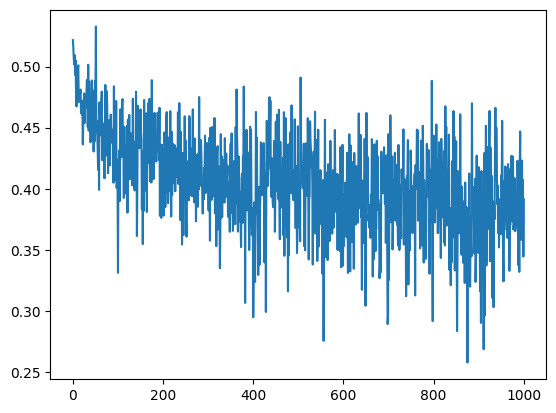

In [156]:
plt.plot(stepi, lossi)

In [157]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.454270124435425
val 2.449648857116699


In [158]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mriahmmyazhrdel.
ndhryal.
lethrstendrlen.
lzerydielinnn.
llopnledellesnanariellyimhlkelin.
shdhvrgxhgriel.
jande.
jelqhxnthulfnu.
zmycdir.
jahlizehshria.
musth.
dazhyl.
nalylisuh.
zalllveulen.
cryvnnveaosu.
nfrdin.
lyxmerishaptin.
samueylh.
hmrerlyin.
miri.


### Summary

In [159]:
g  = torch.Generator().manual_seed(2147483647)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Linear():
    def __init__(self, in_features, out_features, bias=True):
        self.in_features = in_features
        self.out_features = out_features
        self.bias = torch.zeros(out_features) if bias else None
        self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out 
        
    def parameters(self ):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class BatchNorm1d():
    def __init__(self, out_features, training=True, eps=1e-5):
        self.bngain = torch.ones(out_features)
        self.bnbias = torch.zeros(out_features)
        self.bnmean_running = torch.ones(out_features)
        self.bnstd_running = torch.zeros(out_features)
        self.w = 0.1
        self.training = training
        self.eps = eps
        
    def __call__(self, x):
        if self.training:
            h_mean = x.mean(0, keepdim=True)
            h_std = x.var(0, keepdim=True)
            
            with torch.no_grad():
                self.bnstd_running = (1- self.w) * self.bnstd_running + self.w * h_std
                self.bnmean_running = (1- self.w) * self.bnmean_running + self.w * h_mean
        else:
            h_mean = self.bnmean_running
            h_std = self.bnstd_running
            self.out = self.bngain * ((x - self.bnmean_running) / self.bnstd_running) + self.bnbias
        
        xhat = (x - h_mean) / torch.sqrt(h_std + self.eps) # normalize to unit variance
        self.out = self.bngain * xhat + self.bnbias
        
        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]
    
block_size = 3
hid_layer = 100
emb_size = 10

C  = torch.randn((vocab_size, emb_size),                    generator=g)
    
layers = [  Linear(emb_size*block_size, hid_layer,  bias=False), BatchNorm1d(hid_layer), Tanh(),
            Linear(hid_layer,           hid_layer,  bias=False), BatchNorm1d(hid_layer), Tanh(),
            Linear(hid_layer,           hid_layer,  bias=False), BatchNorm1d(hid_layer), Tanh(),
            Linear(hid_layer,           hid_layer,  bias=False), BatchNorm1d(hid_layer), Tanh(),
            Linear(hid_layer,           hid_layer,  bias=False), BatchNorm1d(hid_layer), Tanh(),
            Linear(hid_layer,           vocab_size, bias=False), BatchNorm1d(vocab_size)
        ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].bngain *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3
      
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [160]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


In [161]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.434417963027954
val 2.4324371814727783


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.39%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.75%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.27%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.24%


Text(0.5, 1.0, 'activation distribution')

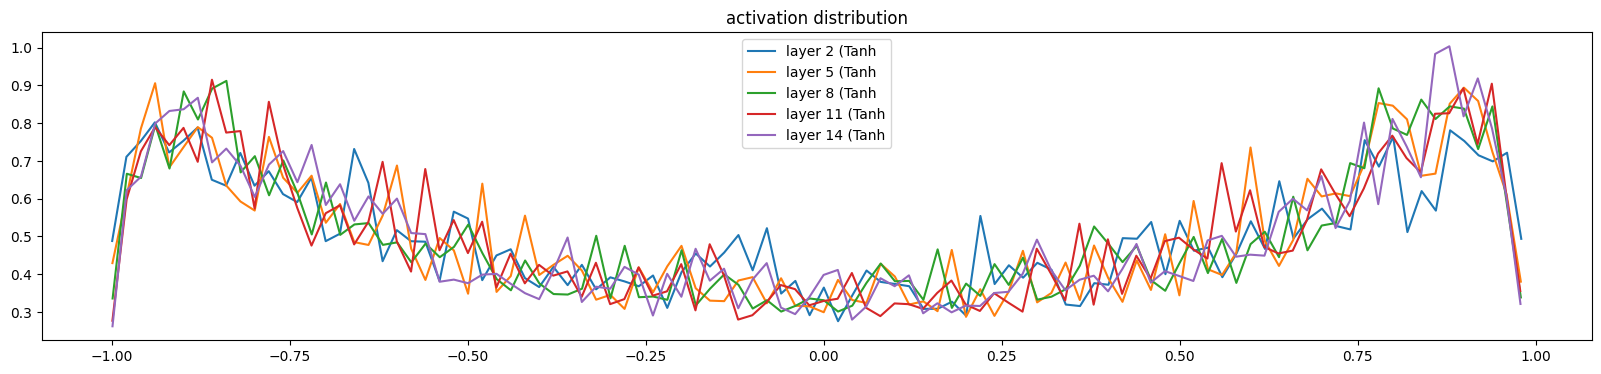

In [162]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


In [163]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 1.019887e-02 | grad:data ratio 1.018847e-02
weight  (30, 100) | mean +0.000092 | std 8.238430e-03 | grad:data ratio 2.635839e-02
weight (100, 100) | mean +0.000031 | std 7.318114e-03 | grad:data ratio 4.377145e-02
weight (100, 100) | mean -0.000019 | std 6.662023e-03 | grad:data ratio 3.949896e-02
weight (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445297e-03 | grad:data ratio 3.243368e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02 | grad:data ratio 6.281266e-02


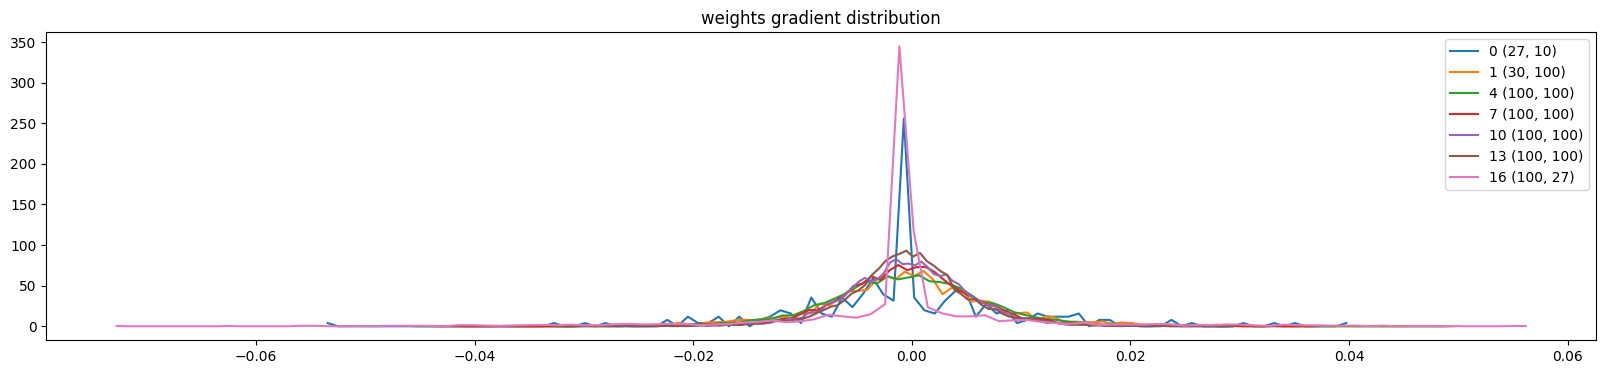

In [141]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

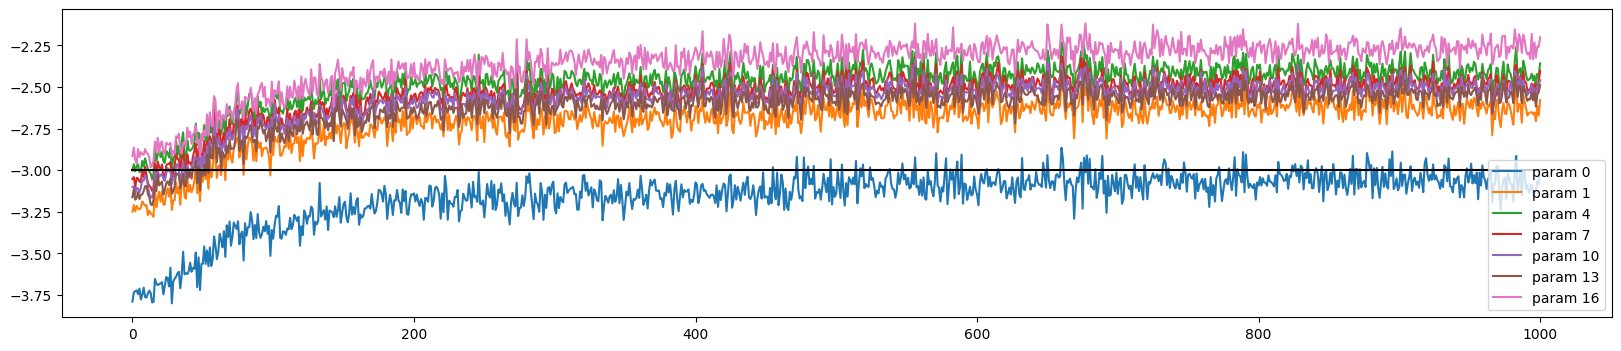

In [142]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### Adding kaiming init
train 2.0376641750335693
val 2.106989622116089

### Batch normalize
train 2.0674192905426025
val 2.105670690536499

### 6 -layer mlp 
train 1.9985263347625732
val 2.0787949562072754


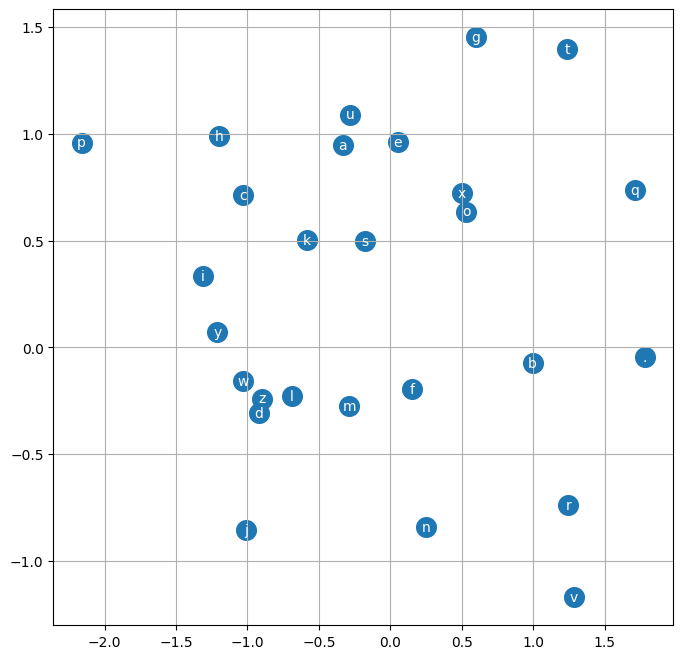

In [143]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

C:\Users\User\AppData\Local\Temp\ipykernel_32008\1836100987.py:42: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  h_std = x.var(0, keepdim=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0